# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [2]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [3]:
EXPERIMENT_NAME = 'Scene3-LSTM4'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 300

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [7]:
len(ds_train), len(ds_test)

(17678, 16975)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([300, 6]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([300, 6])

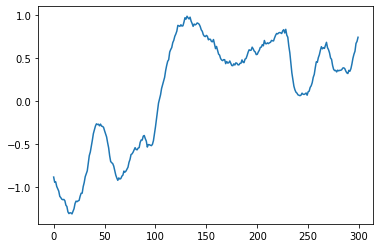

In [11]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [12]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.621435
 - Pitch        :  10.386208
 - Roll         :   2.617061
 - RMS          :  12.402690
 - 99% Tile     :  43.232032
Save output signals into checkpoint/Scene3-LSTM4/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.265602
 - Pitch        :   9.237728
 - Roll         :   2.567597
 - RMS          :  10.407798
 - 99% Tile     :  38.930490
Save output signals into checkpoint/Scene3-LSTM4/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.230296
 - Pitch        :   8.903201
 - Roll         :   2.427008
 - RMS          :   8.845668
 - 99% Tile     :  34.339697
Save output signals into checkpoint/Scene3-LSTM4/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.988942
 - Pitch        :   8.006502
 - Roll         :   2.402825
 - RMS          :   7.520121
 - 99% Tile     :  30.833705
Save output signals into checkpoint/Scene3-LSTM4/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.640498
 - Pitch        :   7.536335
 - Roll         :   2.422422
 - RMS          :   6.765666
 - 99% Tile     :  28.080684
Save output signals into checkpoint/Scene3-LSTM4/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.253839
 - Pitch        :   7.167391
 - Roll         :   2.433434
 - RMS          :   6.052858
 - 99% Tile     :  26.241259
Save output signals into checkpoint/Scene3-LSTM4/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.222514
 - Pitch        :   7.032135
 - Roll         :   2.408512
 - RMS          :   5.596771
 - 99% Tile     :  24.028089
Save output signals into checkpoint/Scene3-LSTM4/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.577657
 - Pitch        :   6.077454
 - Roll         :   2.386796
 - RMS          :   4.957906
 - 99% Tile     :  21.783795
Save output signals into checkpoint/Scene3-LSTM4/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.026242
 - Pitch        :   5.516901
 - Roll         :   2.386137
 - RMS          :   4.523750
 - 99% Tile     :  19.376852
Save output signals into checkpoint/Scene3-LSTM4/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.226198
 - Pitch        :   4.590847
 - Roll         :   2.411891
 - RMS          :   3.862376
 - 99% Tile     :  17.273660
Save output signals into checkpoint/Scene3-LSTM4/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.946361
 - Pitch        :   4.004767
 - Roll         :   2.400743
 - RMS          :   3.529660
 - 99% Tile     :  16.307814
Save output signals into checkpoint/Scene3-LSTM4/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.244602
 - Pitch        :   3.302341
 - Roll         :   2.377935
 - RMS          :   3.004856
 - 99% Tile     :  14.924466
Save output signals into checkpoint/Scene3-LSTM4/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.242997
 - Pitch        :   2.928468
 - Roll         :   2.367722
 - RMS          :   2.869324
 - 99% Tile     :  13.480005
Save output signals into checkpoint/Scene3-LSTM4/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.511717
 - Pitch        :   2.633312
 - Roll         :   2.418075
 - RMS          :   2.522574
 - 99% Tile     :  12.730741
Save output signals into checkpoint/Scene3-LSTM4/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.260005
 - Pitch        :   2.346454
 - Roll         :   2.361204
 - RMS          :   2.322983
 - 99% Tile     :  11.621649
Save output signals into checkpoint/Scene3-LSTM4/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.911681
 - Pitch        :   2.398512
 - Roll         :   2.341797
 - RMS          :   2.563510
 - 99% Tile     :  11.275177
Save output signals into checkpoint/Scene3-LSTM4/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.345218
 - Pitch        :   1.856603
 - Roll         :   2.366150
 - RMS          :   2.201945
 - 99% Tile     :  10.579390
Save output signals into checkpoint/Scene3-LSTM4/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.857784
 - Pitch        :   1.885209
 - Roll         :   2.353315
 - RMS          :   2.044788
 - 99% Tile     :  10.104862
Save output signals into checkpoint/Scene3-LSTM4/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.552439
 - Pitch        :   1.734778
 - Roll         :   2.383733
 - RMS          :   1.923686
 - 99% Tile     :   9.758425
Save output signals into checkpoint/Scene3-LSTM4/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.038468
 - Pitch        :   1.517197
 - Roll         :   2.330684
 - RMS          :   1.990756
 - 99% Tile     :   9.424193
Save output signals into checkpoint/Scene3-LSTM4/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.950280
 - Pitch        :   1.706688
 - Roll         :   2.271102
 - RMS          :   1.989496
 - 99% Tile     :   9.672581
Save output signals into checkpoint/Scene3-LSTM4/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   2.418946
 - Pitch        :   1.795301
 - Roll         :   2.287838
 - RMS          :   2.183927
 - 99% Tile     :   9.366792
Save output signals into checkpoint/Scene3-LSTM4/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.524805
 - Pitch        :   1.335817
 - Roll         :   2.322577
 - RMS          :   1.779869
 - 99% Tile     :   9.088669
Save output signals into checkpoint/Scene3-LSTM4/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.484776
 - Pitch        :   1.798479
 - Roll         :   2.313737
 - RMS          :   2.218259
 - 99% Tile     :   8.797800
Save output signals into checkpoint/Scene3-LSTM4/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.366712
 - Pitch        :   1.319389
 - Roll         :   2.343780
 - RMS          :   1.741838
 - 99% Tile     :   8.664438
Save output signals into checkpoint/Scene3-LSTM4/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.240279
 - Pitch        :   1.224661
 - Roll         :   2.309066
 - RMS          :   1.670317
 - 99% Tile     :   7.941426
Save output signals into checkpoint/Scene3-LSTM4/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.707308
 - Pitch        :   1.260011
 - Roll         :   2.255042
 - RMS          :   1.787712
 - 99% Tile     :   8.167466
Save output signals into checkpoint/Scene3-LSTM4/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.942464
 - Pitch        :   1.499409
 - Roll         :   2.317000
 - RMS          :   1.948494
 - 99% Tile     :   8.141607
Save output signals into checkpoint/Scene3-LSTM4/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.952005
 - Pitch        :   1.296461
 - Roll         :   2.297058
 - RMS          :   1.894519
 - 99% Tile     :   8.003246
Save output signals into checkpoint/Scene3-LSTM4/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.328131
 - Pitch        :   1.329576
 - Roll         :   2.305955
 - RMS          :   1.717472
 - 99% Tile     :   7.813451
Save output signals into checkpoint/Scene3-LSTM4/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.337757
 - Pitch        :   1.172441
 - Roll         :   2.327615
 - RMS          :   1.691351
 - 99% Tile     :   7.494107
Save output signals into checkpoint/Scene3-LSTM4/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.705463
 - Pitch        :   1.176400
 - Roll         :   2.319920
 - RMS          :   1.795787
 - 99% Tile     :   7.842751
Save output signals into checkpoint/Scene3-LSTM4/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.238762
 - Pitch        :   1.409098
 - Roll         :   2.281066
 - RMS          :   1.705223
 - 99% Tile     :   7.472172
Save output signals into checkpoint/Scene3-LSTM4/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   2.130074
 - Pitch        :   1.317793
 - Roll         :   2.235633
 - RMS          :   1.938371
 - 99% Tile     :   7.837205
Save output signals into checkpoint/Scene3-LSTM4/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.446246
 - Pitch        :   1.345467
 - Roll         :   2.285546
 - RMS          :   1.744098
 - 99% Tile     :   8.363981
Save output signals into checkpoint/Scene3-LSTM4/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.799481
 - Pitch        :   1.258714
 - Roll         :   2.334974
 - RMS          :   1.850639
 - 99% Tile     :   7.978023
Save output signals into checkpoint/Scene3-LSTM4/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.186451
 - Pitch        :   1.204289
 - Roll         :   2.276505
 - RMS          :   1.637117
 - 99% Tile     :   8.054919
Save output signals into checkpoint/Scene3-LSTM4/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.737105
 - Pitch        :   1.281105
 - Roll         :   2.264352
 - RMS          :   1.806106
 - 99% Tile     :   8.306055
Save output signals into checkpoint/Scene3-LSTM4/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.191408
 - Pitch        :   1.164897
 - Roll         :   2.255313
 - RMS          :   1.618937
 - 99% Tile     :   7.518993
Save output signals into checkpoint/Scene3-LSTM4/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.250560
 - Pitch        :   1.059851
 - Roll         :   2.260080
 - RMS          :   1.611950
 - 99% Tile     :   7.749263
Save output signals into checkpoint/Scene3-LSTM4/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.194775
 - Pitch        :   1.125702
 - Roll         :   2.277071
 - RMS          :   1.620673
 - 99% Tile     :   7.556527
Save output signals into checkpoint/Scene3-LSTM4/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.674175
 - Pitch        :   1.189573
 - Roll         :   2.279321
 - RMS          :   1.771370
 - 99% Tile     :   8.184522
Save output signals into checkpoint/Scene3-LSTM4/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.245157
 - Pitch        :   1.219408
 - Roll         :   2.281485
 - RMS          :   1.657563
 - 99% Tile     :   7.406883
Save output signals into checkpoint/Scene3-LSTM4/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.177800
 - Pitch        :   1.074372
 - Roll         :   2.248592
 - RMS          :   1.591399
 - 99% Tile     :   7.325613
Save output signals into checkpoint/Scene3-LSTM4/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.827521
 - Pitch        :   1.226872
 - Roll         :   2.270224
 - RMS          :   1.825647
 - 99% Tile     :   7.984317
Save output signals into checkpoint/Scene3-LSTM4/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.591614
 - Pitch        :   1.262902
 - Roll         :   2.263614
 - RMS          :   1.756142
 - 99% Tile     :   7.453036
Save output signals into checkpoint/Scene3-LSTM4/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.196506
 - Pitch        :   1.160617
 - Roll         :   2.253791
 - RMS          :   1.618460
 - 99% Tile     :   7.655377
Save output signals into checkpoint/Scene3-LSTM4/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.239864
 - Pitch        :   1.155905
 - Roll         :   2.216927
 - RMS          :   1.611225
 - 99% Tile     :   7.855047
Save output signals into checkpoint/Scene3-LSTM4/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.020006
 - Pitch        :   1.155202
 - Roll         :   2.185522
 - RMS          :   1.543957
 - 99% Tile     :   7.168608
Save output signals into checkpoint/Scene3-LSTM4/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.380360
 - Pitch        :   1.200142
 - Roll         :   2.218515
 - RMS          :   1.660075
 - 99% Tile     :   7.291759
Save output signals into checkpoint/Scene3-LSTM4/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.083371
 - Pitch        :   1.128337
 - Roll         :   2.219962
 - RMS          :   1.567914
 - 99% Tile     :   7.394718
Save output signals into checkpoint/Scene3-LSTM4/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.096188
 - Pitch        :   1.101618
 - Roll         :   2.241881
 - RMS          :   1.574931
 - 99% Tile     :   7.534625
Save output signals into checkpoint/Scene3-LSTM4/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.966153
 - Pitch        :   1.264812
 - Roll         :   2.258311
 - RMS          :   1.595115
 - 99% Tile     :   7.439618
Save output signals into checkpoint/Scene3-LSTM4/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.243331
 - Pitch        :   1.299915
 - Roll         :   2.224867
 - RMS          :   1.651836
 - 99% Tile     :   7.483417
Save output signals into checkpoint/Scene3-LSTM4/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.059092
 - Pitch        :   1.173517
 - Roll         :   2.226434
 - RMS          :   1.576476
 - 99% Tile     :   7.230645
Save output signals into checkpoint/Scene3-LSTM4/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.090876
 - Pitch        :   1.158560
 - Roll         :   2.162639
 - RMS          :   1.550191
 - 99% Tile     :   7.117776
Save output signals into checkpoint/Scene3-LSTM4/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.159863
 - Pitch        :   1.132246
 - Roll         :   2.169398
 - RMS          :   1.563495
 - 99% Tile     :   7.062903
Save output signals into checkpoint/Scene3-LSTM4/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.194004
 - Pitch        :   1.084022
 - Roll         :   2.193949
 - RMS          :   1.572065
 - 99% Tile     :   7.211020
Save output signals into checkpoint/Scene3-LSTM4/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.021377
 - Pitch        :   1.123494
 - Roll         :   2.200603
 - RMS          :   1.543600
 - 99% Tile     :   7.078262
Save output signals into checkpoint/Scene3-LSTM4/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.016525
 - Pitch        :   1.154684
 - Roll         :   2.168545
 - RMS          :   1.535058
 - 99% Tile     :   7.029942
Save output signals into checkpoint/Scene3-LSTM4/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.942417
 - Pitch        :   1.121948
 - Roll         :   2.179948
 - RMS          :   1.516475
 - 99% Tile     :   6.963511
Save output signals into checkpoint/Scene3-LSTM4/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.148394
 - Pitch        :   1.086779
 - Roll         :   2.110080
 - RMS          :   1.522316
 - 99% Tile     :   6.904934
Save output signals into checkpoint/Scene3-LSTM4/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.448271
 - Pitch        :   1.247674
 - Roll         :   2.075027
 - RMS          :   1.628897
 - 99% Tile     :   7.151389
Save output signals into checkpoint/Scene3-LSTM4/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.079620
 - Pitch        :   1.181684
 - Roll         :   1.974119
 - RMS          :   1.467322
 - 99% Tile     :   6.650124
Save output signals into checkpoint/Scene3-LSTM4/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.150304
 - Pitch        :   1.221005
 - Roll         :   1.763480
 - RMS          :   1.405218
 - 99% Tile     :   6.613557
Save output signals into checkpoint/Scene3-LSTM4/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.196110
 - Pitch        :   1.109651
 - Roll         :   1.563111
 - RMS          :   1.304521
 - 99% Tile     :   6.636183
Save output signals into checkpoint/Scene3-LSTM4/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.101105
 - Pitch        :   1.100186
 - Roll         :   1.431622
 - RMS          :   1.220981
 - 99% Tile     :   6.410626
Save output signals into checkpoint/Scene3-LSTM4/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.173363
 - Pitch        :   1.028353
 - Roll         :   1.314116
 - RMS          :   1.177737
 - 99% Tile     :   6.308761
Save output signals into checkpoint/Scene3-LSTM4/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.242707
 - Pitch        :   1.017589
 - Roll         :   1.252167
 - RMS          :   1.175830
 - 99% Tile     :   6.359763
Save output signals into checkpoint/Scene3-LSTM4/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.023317
 - Pitch        :   1.152659
 - Roll         :   1.174526
 - RMS          :   1.118826
 - 99% Tile     :   6.259284
Save output signals into checkpoint/Scene3-LSTM4/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.002041
 - Pitch        :   1.088714
 - Roll         :   1.149673
 - RMS          :   1.081840
 - 99% Tile     :   6.104821
Save output signals into checkpoint/Scene3-LSTM4/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.056501
 - Pitch        :   0.967645
 - Roll         :   1.026489
 - RMS          :   1.017548
 - 99% Tile     :   6.212826
Save output signals into checkpoint/Scene3-LSTM4/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.970863
 - Pitch        :   0.962915
 - Roll         :   1.050780
 - RMS          :   0.995644
 - 99% Tile     :   6.190431
Save output signals into checkpoint/Scene3-LSTM4/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.050746
 - Pitch        :   0.861411
 - Roll         :   0.991329
 - RMS          :   0.971052
 - 99% Tile     :   5.882352
Save output signals into checkpoint/Scene3-LSTM4/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.964954
 - Pitch        :   0.804905
 - Roll         :   0.935082
 - RMS          :   0.904320
 - 99% Tile     :   5.864473
Save output signals into checkpoint/Scene3-LSTM4/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.030140
 - Pitch        :   0.859927
 - Roll         :   0.940898
 - RMS          :   0.946212
 - 99% Tile     :   5.976442
Save output signals into checkpoint/Scene3-LSTM4/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.098432
 - Pitch        :   0.985113
 - Roll         :   0.912344
 - RMS          :   1.001560
 - 99% Tile     :   6.107803
Save output signals into checkpoint/Scene3-LSTM4/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.037701
 - Pitch        :   0.858563
 - Roll         :   0.921180
 - RMS          :   0.942077
 - 99% Tile     :   6.256352
Save output signals into checkpoint/Scene3-LSTM4/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.960499
 - Pitch        :   0.915963
 - Roll         :   0.869616
 - RMS          :   0.916111
 - 99% Tile     :   6.113009
Save output signals into checkpoint/Scene3-LSTM4/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.959108
 - Pitch        :   1.003005
 - Roll         :   0.821553
 - RMS          :   0.931103
 - 99% Tile     :   5.974143
Save output signals into checkpoint/Scene3-LSTM4/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.982738
 - Pitch        :   0.980767
 - Roll         :   0.869159
 - RMS          :   0.945712
 - 99% Tile     :   5.930452
Save output signals into checkpoint/Scene3-LSTM4/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.002962
 - Pitch        :   0.952833
 - Roll         :   0.880680
 - RMS          :   0.946823
 - 99% Tile     :   5.940721
Save output signals into checkpoint/Scene3-LSTM4/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.929383
 - Pitch        :   0.815024
 - Roll         :   0.863117
 - RMS          :   0.870438
 - 99% Tile     :   5.939425
Save output signals into checkpoint/Scene3-LSTM4/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.909631
 - Pitch        :   0.854536
 - Roll         :   0.811049
 - RMS          :   0.859353
 - 99% Tile     :   5.900517
Save output signals into checkpoint/Scene3-LSTM4/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.069211
 - Pitch        :   0.934240
 - Roll         :   0.857983
 - RMS          :   0.957802
 - 99% Tile     :   6.010191
Save output signals into checkpoint/Scene3-LSTM4/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.951753
 - Pitch        :   0.850291
 - Roll         :   0.853224
 - RMS          :   0.886345
 - 99% Tile     :   5.894866
Save output signals into checkpoint/Scene3-LSTM4/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.000440
 - Pitch        :   0.886680
 - Roll         :   0.888290
 - RMS          :   0.926668
 - 99% Tile     :   5.921368
Save output signals into checkpoint/Scene3-LSTM4/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.911006
 - Pitch        :   0.987591
 - Roll         :   0.801616
 - RMS          :   0.903301
 - 99% Tile     :   5.973368
Save output signals into checkpoint/Scene3-LSTM4/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.989431
 - Pitch        :   0.809763
 - Roll         :   0.822688
 - RMS          :   0.877782
 - 99% Tile     :   5.862741
Save output signals into checkpoint/Scene3-LSTM4/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.957873
 - Pitch        :   0.913794
 - Roll         :   0.819714
 - RMS          :   0.898975
 - 99% Tile     :   5.877176
Save output signals into checkpoint/Scene3-LSTM4/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.952064
 - Pitch        :   0.854780
 - Roll         :   0.814649
 - RMS          :   0.875734
 - 99% Tile     :   5.959435
Save output signals into checkpoint/Scene3-LSTM4/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.887153
 - Pitch        :   0.925761
 - Roll         :   0.814934
 - RMS          :   0.877153
 - 99% Tile     :   5.888977
Save output signals into checkpoint/Scene3-LSTM4/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/70 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.959324
 - Pitch        :   0.859247
 - Roll         :   0.838404
 - RMS          :   0.887230
 - 99% Tile     :   5.987449
Save output signals into checkpoint/Scene3-LSTM4/sample/0093.npy


[0094/0100] Validation: 100%|██████████████████████| 67/67 [00:04<00:00, 13.50it/s, val_loss 2.2232]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.942433
 - Pitch        :   0.785079
 - Roll         :   0.813676
 - RMS          :   0.849823
 - 99% Tile     :   5.972516
Save output signals into checkpoint/Scene3-LSTM4/sample/0094.npy
